# MLB Pitch Classification
**Author**: Eric Wehmueller
***

## Overview

This project is the final/Capstone project for Flatiron School's bootcamp program in Data Science.  We have created a hypothetical situation as a Data Scientist and are hoping to provide value to our business for the scenario.

## Business Problem

A hot topic in the 2021 Major League Baseball season surrounds discussion about certain substances being used by pitchers to increase their "spin rate"- an advanced metric now being recorded on every pitch by sophisticated cameras.  The argument is that a higher spin rate on pitches gives better results, and this substance is legal and used by a high percentage of pitchers around the league.  However, this is not the singular determining factor in throwing an effective pitch: namely, one that will cause a Major League better to swing and miss. Although typically regarded as an "old man's game", can we get a step ahead of the game and leverage this metric and a variety of other data on pitches to know what types of pitches will give us the best results?  

We have been hired as a hypothetical member of the Cardinals baseball organization: a member of the coaching staff.  As a coaching analyst, our job is to create a model that will give us insights into pitch quality and classify a pitch, given its metrics, as a "strike" or a red flag "hit" for our opponent.

## Project Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_graphviz, plot_tree
from IPython.display import Image
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import plot_tree

In [3]:
from pybaseball import playerid_lookup, statcast_batter, statcast_pitcher

## Data Exploration

To start, let's see if we can get some immediate value in our current season against one particular player giving us trouble. So far in the 2021 season, Jesse Winker, a member of the Cincinnati Reds, has proven himself as an elite hitter.  Since we are in the same division as this team (NL Central), he is going to be in the batters' box against our pitchers extremely often.  If we can find a way to mitigate the damage he does against our ball club, that would be ideal. Let's work towards creating a model specifically for this.

In [4]:
player_info_df = playerid_lookup('winker','jesse')
player_info_df.head()

Gathering player lookup table. This may take a moment.


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,winker,jesse,608385,winkj002,winkeje01,13590,2017.0,2021.0


In [5]:
jwinker_id = 608385
#statcast data (data per pitch, goes back to 2015)
df = statcast_batter('2016-08-01','2021-08-01', jwinker_id)

Gathering Player Data


In [6]:
df.shape

(5805, 92)

In [7]:
print(df.columns.tolist())

['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher', 'events', 'description', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des', 'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 

In [8]:
pd.set_option('max_columns', 100)
pd.set_option('display.max_colwidth', None)
df.head(5)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,FS,2021-08-01,86.5,-1.24,5.28,"Winker, Jesse",608385,573186,double,hit_into_play,NaN,NaN,NaN,NaN,14.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,X,4.0,ground_ball,1,2,2021,-0.94,-0.10,0.28,0.64,NaN,NaN,NaN,0,6,Top,126.0,204.5,NaN,NaN,621512,NaN,NaN,5.470293,-125.956504,-4.687578,-11.032610,22.430124,-32.573620,3.49,1.60,72.0,85.4,4.0,85.9,1767.0,5.6,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.91,0.363,0.35,1.25,1.0,1.0,1.0,2.0,37,5,Split-Finger,0,1,1,0,1,0,1,0,Infield shift,Standard,242.0,-0.068,0.707
1,FS,2021-08-01,88.3,-1.22,5.26,"Winker, Jesse",608385,573186,NaN,foul,NaN,NaN,NaN,NaN,8.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,S,NaN,NaN,1,2,2021,-0.69,-0.51,-0.15,1.84,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,3.988880,-128.595114,-1.212061,-8.478128,25.878591,-37.828954,3.49,1.60,NaN,NaN,NaN,87.4,1902.0,5.6,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,4,Split-Finger,0,1,1,0,1,0,1,0,Infield shift,Standard,243.0,0.000,0.000
2,FC,2021-08-01,90.4,-1.37,5.24,"Winker, Jesse",608385,573186,NaN,foul,NaN,NaN,NaN,NaN,2.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,S,NaN,NaN,1,1,2021,0.23,0.85,0.06,3.21,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,3.061059,-131.745523,-1.004938,2.110204,24.609554,-22.198202,3.49,1.60,219.0,73.4,28.0,90.2,2743.0,5.8,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,3,Cutter,0,1,1,0,1,0,1,0,Infield shift,Standard,213.0,0.000,-0.056
3,SL,2021-08-01,86.2,-1.27,5.27,"Winker, Jesse",608385,573186,NaN,ball,NaN,NaN,NaN,NaN,14.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,B,NaN,NaN,0,1,2021,0.94,0.16,1.97,-0.32,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,5.749211,-125.440565,-7.388813,9.023742,22.363264,-29.337223,3.32,1.52,NaN,NaN,NaN,86.0,2937.0,5.9,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,2,Slider,0,1,1,0,1,0,1,0,Infield shift,Standard,49.0,0.000,0.028
4,SI,2021-08-01,91.2,-1.23,5.29,"Winker, Jesse",608385,573186,NaN,foul,NaN,NaN,NaN,NaN,4.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,S,NaN,NaN,0,0,2021,-0.96,0.18,-0.64,2.45,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,3.502166,-133.082664,-1.781584,-12.223426,21.352922,-29.919013,3.49,1.60,228.0,76.4,45.0,91.7,2482.0,5.9,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,1,Sinker,0,1,1,0,1,0,1,0,Infield shift,Standard,218.0,0.000,-0.038


Needs Exact Clarification:
***

pfx_x, pfx_z

plate_x, plate_z

vx0, vy0, vz0

ax, ay, az

sz_top, sz_bot

spin_axis

zone


***
***
Other potentially relevant features for our model:
***
pitch_type/pitch_name, pitch_number

release_speed

release_pos_x, release_pos_z

events, description

stand, p_throws

balls, strikes

release_spin_rate, release_extension

***

Documentation on the specifics of these metrics can be found at https://baseballsavant.mlb.com/csv-docs







In [9]:
#looking to remove "intent_ball", this is not a pitch that has the intention
#of making the hitter swing, so we could remove these
df['description'].unique().tolist()

['hit_into_play',
 'foul',
 'ball',
 'swinging_strike',
 'called_strike',
 'foul_tip',
 'blocked_ball',
 'swinging_strike_blocked',
 'hit_by_pitch',
 'foul_bunt',
 'missed_bunt']

From this list, we could make our target column for classification purposes. Namely, 1 for a swing and 0 for a non-swing to keep it simple.  We could make this more sophisticated later if need be.. For example- can we get ahead in the count by forcing foul balls? Or maybe "hit_into_play" is not always bad- forcing an easy infield ground ball is also an easy way to get a batter out)

In [10]:
df['pitch_type'].unique().tolist()

['FS', 'FC', 'SL', 'SI', 'FF', 'CU', 'CH', 'KC', 'FT', nan, 'FO', 'KN']

In [11]:
#checking for nulls in pitch location/speed data, this is important
print(df['pitch_type'].isna().sum())
print(df['release_speed'].isna().sum())
print(df['plate_x'].isna().sum())
print(df['plate_z'].isna().sum())

51
48
49
49


In [12]:
df2 = df.loc[(df['pitch_type'].notnull()) & (df['release_speed'].notnull())
            & (df['plate_x'].notnull()) & (df['plate_z'].notnull())]
print(df2.shape)
df2.head()

(5754, 92)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,FS,2021-08-01,86.5,-1.24,5.28,"Winker, Jesse",608385,573186,double,hit_into_play,NaN,NaN,NaN,NaN,14.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,X,4.0,ground_ball,1,2,2021,-0.94,-0.10,0.28,0.64,NaN,NaN,NaN,0,6,Top,126.0,204.5,NaN,NaN,621512,NaN,NaN,5.470293,-125.956504,-4.687578,-11.032610,22.430124,-32.573620,3.49,1.60,72.0,85.4,4.0,85.9,1767.0,5.6,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.91,0.363,0.35,1.25,1.0,1.0,1.0,2.0,37,5,Split-Finger,0,1,1,0,1,0,1,0,Infield shift,Standard,242.0,-0.068,0.707
1,FS,2021-08-01,88.3,-1.22,5.26,"Winker, Jesse",608385,573186,NaN,foul,NaN,NaN,NaN,NaN,8.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,S,NaN,NaN,1,2,2021,-0.69,-0.51,-0.15,1.84,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,3.988880,-128.595114,-1.212061,-8.478128,25.878591,-37.828954,3.49,1.60,NaN,NaN,NaN,87.4,1902.0,5.6,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,4,Split-Finger,0,1,1,0,1,0,1,0,Infield shift,Standard,243.0,0.000,0.000
2,FC,2021-08-01,90.4,-1.37,5.24,"Winker, Jesse",608385,573186,NaN,foul,NaN,NaN,NaN,NaN,2.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,S,NaN,NaN,1,1,2021,0.23,0.85,0.06,3.21,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,3.061059,-131.745523,-1.004938,2.110204,24.609554,-22.198202,3.49,1.60,219.0,73.4,28.0,90.2,2743.0,5.8,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,3,Cutter,0,1,1,0,1,0,1,0,Infield shift,Standard,213.0,0.000,-0.056
3,SL,2021-08-01,86.2,-1.27,5.27,"Winker, Jesse",608385,573186,NaN,ball,NaN,NaN,NaN,NaN,14.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,B,NaN,NaN,0,1,2021,0.94,0.16,1.97,-0.32,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,5.749211,-125.440565,-7.388813,9.023742,22.363264,-29.337223,3.32,1.52,NaN,NaN,NaN,86.0,2937.0,5.9,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,2,Slider,0,1,1,0,1,0,1,0,Infield shift,Standard,49.0,0.000,0.028
4,SI,2021-08-01,91.2,-1.23,5.29,"Winker, Jesse",608385,573186,NaN,foul,NaN,NaN,NaN,NaN,4.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,S,NaN,NaN,0,0,2021,-0.96,0.18,-0.64,2.45,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,3.502166,-133.082664,-1.781584,-12.223426,21.352922,-29.919013,3.49,1.60,228.0,76.4,45.0,91.7,2482.0,5.9,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,1,Sinker,0,1,1,0,1,0,1,0,Infield shift,Standard,218.0,0.000,-0.038


Additionally, I am going to attempt to classify events as favorable or unfavorable for the pitcher, denoted by 1, 0, or -1.

I'll engineer a field "swing_for_stk_or_out" to denonte the difference between a swing, which could have a wide variety of outcomes (home run vs a called strike, for example). I'll only count swings that register a strike or an out as a 1 in this field, balls as a zero, and very negative pitcher outcomes as -1 (hits, walks, and sac flies). We'll have to look at both the 'description' column as well as the 'events' column to achieve this.

In [13]:
df2['swing_stk_or_out'] = 0

<ipython-input-13-ad41a3d6c6ec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['swing_stk_or_out'] = 0


In [14]:
df2['events'].unique().tolist()

['double',
 nan,
 'strikeout',
 'field_out',
 'walk',
 'single',
 'home_run',
 'grounded_into_double_play',
 'fielders_choice',
 'field_error',
 'force_out',
 'hit_by_pitch',
 'fielders_choice_out',
 'triple',
 'sac_fly',
 'caught_stealing_2b',
 'strikeout_double_play',
 'sac_bunt']

In [16]:
df2.loc[df2['description'].isin(['hit_into_play', 'foul', 'swinging_strike',
 'called_strike', 'foul_tip', 'swinging_strike_blocked', 'foul_bunt',
 'missed_bunt']), 'swing_stk_or_out'] = 1

C:\Users\Darko\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [17]:
df2.loc[df2['events'].isin(['double', 'walk', 'single',
 'home_run', 'triple', 'sac_fly']), 'swing_stk_or_out'] = -1

In [18]:
df2.head(20)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,swing_stk_or_out
0,FS,2021-08-01,86.5,-1.24,5.28,"Winker, Jesse",608385,573186,double,hit_into_play,NaN,NaN,NaN,NaN,14.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,X,4.0,ground_ball,1,2,2021,-0.94,-0.10,0.28,0.64,NaN,NaN,NaN,0,6,Top,126.00,204.50,NaN,NaN,621512,NaN,NaN,5.470293,-125.956504,-4.687578,-11.032610,22.430124,-32.573620,3.49,1.60,72.0,85.4,4.0,85.9,1767.0,5.6,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.91,0.363,0.35,1.25,1.0,1.0,1.0,2.0,37,5,Split-Finger,0,1,1,0,1,0,1,0,Infield shift,Standard,242.0,-0.068,0.707,-1
1,FS,2021-08-01,88.3,-1.22,5.26,"Winker, Jesse",608385,573186,NaN,foul,NaN,NaN,NaN,NaN,8.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,S,NaN,NaN,1,2,2021,-0.69,-0.51,-0.15,1.84,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,3.988880,-128.595114,-1.212061,-8.478128,25.878591,-37.828954,3.49,1.60,NaN,NaN,NaN,87.4,1902.0,5.6,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,4,Split-Finger,0,1,1,0,1,0,1,0,Infield shift,Standard,243.0,0.000,0.000,1
2,FC,2021-08-01,90.4,-1.37,5.24,"Winker, Jesse",608385,573186,NaN,foul,NaN,NaN,NaN,NaN,2.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,S,NaN,NaN,1,1,2021,0.23,0.85,0.06,3.21,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,3.061059,-131.745523,-1.004938,2.110204,24.609554,-22.198202,3.49,1.60,219.0,73.4,28.0,90.2,2743.0,5.8,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,3,Cutter,0,1,1,0,1,0,1,0,Infield shift,Standard,213.0,0.000,-0.056,1
3,SL,2021-08-01,86.2,-1.27,5.27,"Winker, Jesse",608385,573186,NaN,ball,NaN,NaN,NaN,NaN,14.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,B,NaN,NaN,0,1,2021,0.94,0.16,1.97,-0.32,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,5.749211,-125.440565,-7.388813,9.023742,22.363264,-29.337223,3.32,1.52,NaN,NaN,NaN,86.0,2937.0,5.9,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,2,Slider,0,1,1,0,1,0,1,0,Infield shift,Standard,49.0,0.000,0.028,0
4,SI,2021-08-01,91.2,-1.23,5.29,"Winker, Jesse",608385,573186,NaN,foul,NaN,NaN,NaN,NaN,4.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,S,NaN,NaN,0,0,2021,-0.96,0.18,-0.64,2.45,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,3.502166,-133.082664,-1.781584,-12.223426,21.352922,-29.919013,3.49,1.60,228.0,76.4,45.0,91.7,2482.0,5.9,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,1,Sinker,0,1,1,0,1,0,1,0,Infield shift,Standard,218.0,0.000,-0.038,1
5,FF,2021-08-01,93.1,-1.22,5.34,"Winker, Jesse",608385,573186,strikeout,swinging_strike,NaN,NaN,NaN,NaN,12.0,Jesse Winker strikes out swinging.,R,L,R,NYM,CIN,S,2.

In [19]:
df2['pitch_type'].unique().tolist()

['FS', 'FC', 'SL', 'SI', 'FF', 'CU', 'CH', 'KC', 'FT', 'FO', 'KN']

I'm going to simplify this into 2 types of pitches- fastball or offspeed for our model.

In [20]:
fastballs = ['FC', 'SI', 'FF','FT']
offspeeds = ['FS', 'SL', 'CU', 'CH', 'KC', 'FO', 'KN']

In [21]:
df2['is_fastball'] = 0

<ipython-input-21-516ffa13e6da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['is_fastball'] = 0


In [22]:
df2.loc[df2['pitch_type'].isin(fastballs), 'is_fastball'] = 1

C:\Users\Darko\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [23]:
df2.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,swing_stk_or_out,is_fastball
0,FS,2021-08-01,86.5,-1.24,5.28,"Winker, Jesse",608385,573186,double,hit_into_play,NaN,NaN,NaN,NaN,14.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,X,4.0,ground_ball,1,2,2021,-0.94,-0.10,0.28,0.64,NaN,NaN,NaN,0,6,Top,126.0,204.5,NaN,NaN,621512,NaN,NaN,5.470293,-125.956504,-4.687578,-11.032610,22.430124,-32.573620,3.49,1.60,72.0,85.4,4.0,85.9,1767.0,5.6,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.91,0.363,0.35,1.25,1.0,1.0,1.0,2.0,37,5,Split-Finger,0,1,1,0,1,0,1,0,Infield shift,Standard,242.0,-0.068,0.707,-1,0
1,FS,2021-08-01,88.3,-1.22,5.26,"Winker, Jesse",608385,573186,NaN,foul,NaN,NaN,NaN,NaN,8.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,S,NaN,NaN,1,2,2021,-0.69,-0.51,-0.15,1.84,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,3.988880,-128.595114,-1.212061,-8.478128,25.878591,-37.828954,3.49,1.60,NaN,NaN,NaN,87.4,1902.0,5.6,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,4,Split-Finger,0,1,1,0,1,0,1,0,Infield shift,Standard,243.0,0.000,0.000,1,0
2,FC,2021-08-01,90.4,-1.37,5.24,"Winker, Jesse",608385,573186,NaN,foul,NaN,NaN,NaN,NaN,2.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,S,NaN,NaN,1,1,2021,0.23,0.85,0.06,3.21,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,3.061059,-131.745523,-1.004938,2.110204,24.609554,-22.198202,3.49,1.60,219.0,73.4,28.0,90.2,2743.0,5.8,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,3,Cutter,0,1,1,0,1,0,1,0,Infield shift,Standard,213.0,0.000,-0.056,1,1
3,SL,2021-08-01,86.2,-1.27,5.27,"Winker, Jesse",608385,573186,NaN,ball,NaN,NaN,NaN,NaN,14.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,B,NaN,NaN,0,1,2021,0.94,0.16,1.97,-0.32,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,5.749211,-125.440565,-7.388813,9.023742,22.363264,-29.337223,3.32,1.52,NaN,NaN,NaN,86.0,2937.0,5.9,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,2,Slider,0,1,1,0,1,0,1,0,Infield shift,Standard,49.0,0.000,0.028,0,0
4,SI,2021-08-01,91.2,-1.23,5.29,"Winker, Jesse",608385,573186,NaN,foul,NaN,NaN,NaN,NaN,4.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,S,NaN,NaN,0,0,2021,-0.96,0.18,-0.64,2.45,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,3.502166,-133.082664,-1.781584,-12.223426,21.352922,-29.919013,3.49,1.60,228.0,76.4,45.0,91.7,2482.0,5.9,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,1,Sinker,0,1,1,0,1,0,1,0,Infield shift,Standard,218.0,0.000,-0.038,1,1


In [24]:
df2['is_pitcher_righty'] = 0

<ipython-input-24-7ac8acdb1d98>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['is_pitcher_righty'] = 0


In [25]:
df2.loc[df2['p_throws'] == 'R', 'is_pitcher_righty'] = 1

C:\Users\Darko\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [26]:
model_df = df2[['is_fastball','is_pitcher_righty','release_speed',
                  'plate_x','plate_z','pfx_x','pfx_z','vx0','vy0','vz0',
                  'ax','ay','az','release_spin_rate',
                  'strikes','balls','swing_stk_or_out']]
model_df.head(50)

,is_fastball,is_pitcher_righty,release_speed,plate_x,plate_z,pfx_x,pfx_z,vx0,vy0,vz0,ax,ay,az,release_spin_rate,strikes,balls,swing_stk_or_out
0,0,1,86.5,0.28,0.64,-0.94,-0.10,5.470293,-125.956504,-4.687578,-11.032610,22.430124,-32.573620,1767.0,2,1,-1
1,0,1,88.3,-0.15,1.84,-0.69,-0.51,3.988880,-128.595114,-1.212061,-8.478128,25.878591,-37.828954,1902.0,2,1,1
2,1,1,90.4,0.06,3.21,0.23,0.85,3.061059,-131.745523,-1.004938,2.110204,24.609554,-22.198202,2743.0,1,1,1
3,0,1,86.2,1.97,-0.32,0.94,0.16,5.749211,-125.440565,-7.388813,9.023742,22.363264,-29.337223,2937.0,1,0,0
4,1,1,91.2,-0.64,2.45,-0.96,0.18,3.502166,-133.082664,-1.781584,-12.223426,21.352922,-29.919013,2482.0,0,0,1
5,1,1,93.1,0.00,3.79,-0.33,1.03,3.822021,-135.744296,-0.561437,-4.826120,25.275468,-19.386844,2487.0,2,2,1
6,0,1,84.9,-0.03,2.78,1.14,0.32,0.956030,-123.955315,-0.433315,11.837550,18.606104,-28.952408,2539.0,1,2,1
7,0,1,84.6,-0.20,2.92,0.80,0.23,1.381606,-123.385997,0.390213,8.063831,21.376316,-30.046890,2669.0,0,2,1
8,1,1,92.8,-1.27,1.74,-0.66,0.25,1.410019,-135.244894,-3.871757,-8.459930,26.329627,-28.519733,2285.0,0,1,0
9,0,1,88.4,-1.40,1.20,-1.07,-0.05,2.012130,-128.798705,-3.800888,-12.401942,23.992851,-32.268301,1564.0,0,0,0


In [27]:
model_df = model_df.iloc[::-1]

In [28]:
model_df.head(30)

,is_fastball,is_pitcher_righty,release_speed,plate_x,plate_z,pfx_x,pfx_z,vx0,vy0,vz0,ax,ay,az,release_spin_rate,strikes,balls,swing_stk_or_out
5804,0,1,82.8,0.01,2.80,-1.00,0.51,-0.499430,-120.550634,-2.599534,-9.678987,21.891396,-26.951538,851.0,0,0,1
5803,1,1,92.1,-0.22,1.46,-1.07,1.51,1.261450,-133.740565,-9.393077,-13.286912,27.793748,-12.100016,2092.0,1,0,1
5802,0,1,82.2,-1.11,0.74,-0.80,0.53,-2.965618,-119.385510,-7.071416,-7.084143,23.466330,-25.879091,782.0,2,0,0
5801,0,1,81.6,-0.99,0.89,-1.06,0.48,-2.518183,-118.542927,-6.689493,-9.596888,22.866890,-26.551975,774.0,2,1,1
5800,1,1,93.0,0.22,2.01,0.09,1.62,6.900506,-134.958910,-6.211075,-0.326430,27.123717,-11.361783,2275.0,0,0,-1
5799,1,1,93.9,-0.62,3.41,-0.95,1.74,7.535492,-135.851034,-4.300729,-13.390597,34.955486,-10.447934,2429.0,0,0,-1
5798,1,1,91.1,-0.07,3.25,-0.98,1.59,3.158312,-132.160425,-4.500311,-11.839880,29.046797,-13.388146,2172.0,0,0,1
5797,0,1,76.1,0.91,2.49,1.06,-0.85,5.309346,-110.416138,1.400994,7.362015,21.794727,-39.498229,2666.0,0,0,1
5796,0,1,85.7,-0.43,3.28,-1.59,0.47,8.582171,-124.345429,-0.315679,-18.332180,24.865167,-27.417586,1858.0,1,0,1
5795,0,1,86.7,-0.71,0.55,-1.84,0.29,8.595478,-125.778843,-6.559372,-21.443224,25.258661,-27.897009,1859.0,2,0,1


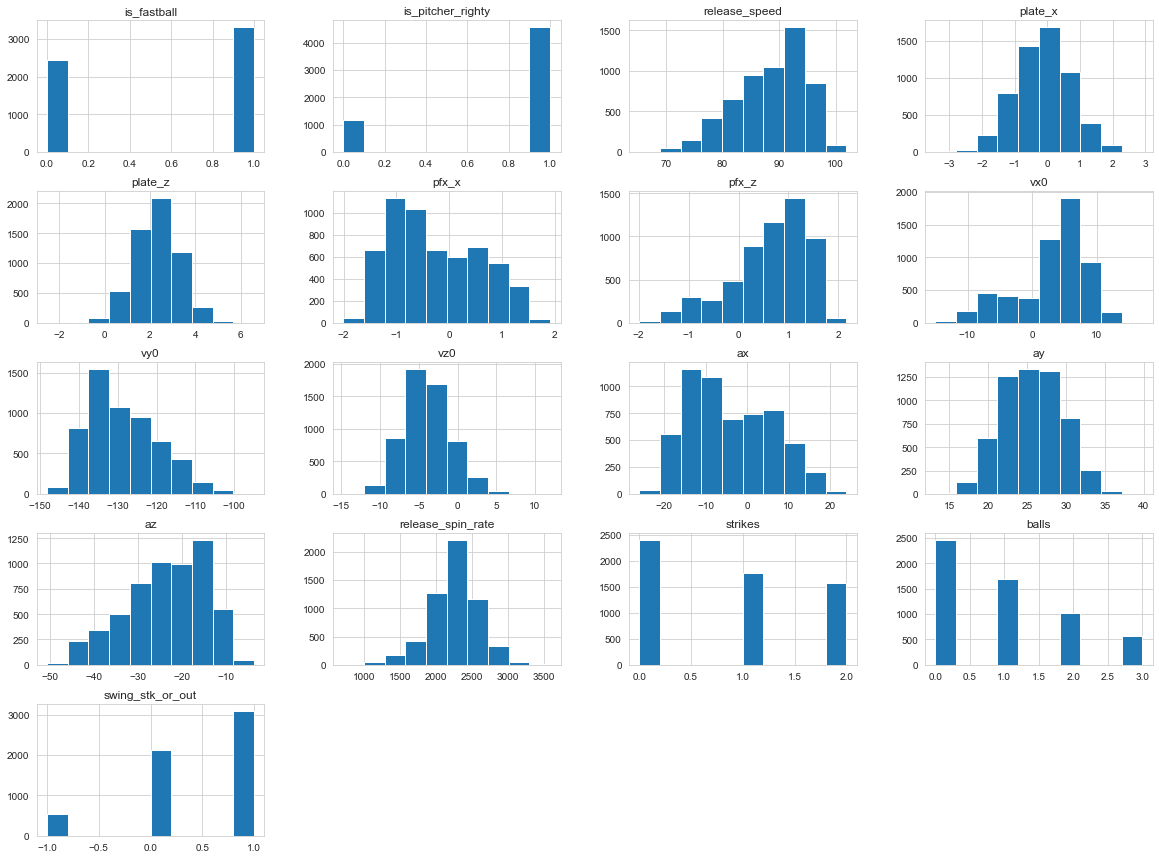

In [29]:
sns.set_style("whitegrid")
model_df.hist(figsize = (20,15));

In [31]:
#checking for nulls/nans again here before modeling phase
model_df.isnull().sum(axis = 0)

is_fastball           0
is_pitcher_righty     0
release_speed         0
plate_x               0
plate_z               0
pfx_x                 0
pfx_z                 0
vx0                   0
vy0                   0
vz0                   0
ax                    0
ay                    0
az                    0
release_spin_rate    61
strikes               0
balls                 0
swing_stk_or_out      0
dtype: int64

In [32]:
print(model_df.shape)
model_df = model_df.dropna()
print(model_df.shape)

model_df.isnull().sum(axis = 0)

(5754, 17)
(5693, 17)


is_fastball          0
is_pitcher_righty    0
release_speed        0
plate_x              0
plate_z              0
pfx_x                0
pfx_z                0
vx0                  0
vy0                  0
vz0                  0
ax                   0
ay                   0
az                   0
release_spin_rate    0
strikes              0
balls                0
swing_stk_or_out     0
dtype: int64

Let's take a look at which features correlate the most to our target outcome ('swing_stk_or_out').

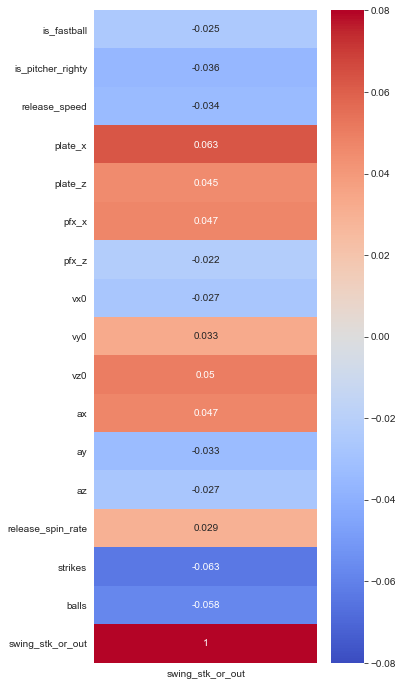

In [33]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=(5, 12))
sns.heatmap(model_df.corr()[['swing_stk_or_out']], annot=True, 
            cmap="coolwarm", vmin=-0.08, vmax=0.08);

This is interesting to see, but I'm not sure how interpretable this is for some features. For example, increasingly negative values for 'pfx_x' indicate more movement from Right to Left, whereas higher positive values indicate more movement from Left to Right. We should probably be taking the absolute value of this field for being able to comment on Jesse Winker's ability to handle general horizonal movement, but losing information on the direction of the movement is not ideal here.

However, it is worth noting that higher "plate_x" and "plate_z" values tends towards positive pitcher outcomes, meaning that pitches up and/or inside (relative to our left-handed hitter Jesse Winker) more often result in a positive outcome for our pitcher.

Additionally, there is somewhat of a correlation between the handedness of the pitcher and the outcome.  This indicates that lower values for "is_pitcher_righty" typically result in positive outcomes for our pitcher. In other words, left handed pitchers seem to have a better time against Jesse, who is also a left handed hitter.  This is reassuring, as it is a commonly held belief that handedness mismatches tend to favor the batter. The data here confirms there is some value in this sentiment. This is why some players opt to switch-hit; even though they might be weaker on one side, they believe this handedness mismatch to be a more important determining factor in their success.

Additionally, there seems to also be a strong correlation between the number of balls or strikes and the outcome.  This seems to indicate that Jesse may start to catch on to the pitch sequence during the at-bat, or be able to more easily predict the next pitch as an at-bat drags on.  The best chance for success for our pitchers is to get him to guess early, as to not "show our hand" so to speak.


## Basic Model

In [34]:
X1= model_df.drop('swing_stk_or_out', 1)
y1= model_df['swing_stk_or_out']

X_train, X_test, y_train, y_test = train_test_split(X1,y1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4269, 16), (1424, 16), (4269,), (1424,))

In [35]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [36]:
y_pred_train = nb.predict(X_train)
y_pred_test = nb.predict(X_test)

In [37]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          -1       0.27      0.24      0.25       142
           0       0.82      0.73      0.77       532
           1       0.74      0.81      0.78       750

    accuracy                           0.72      1424
   macro avg       0.61      0.59      0.60      1424
weighted avg       0.72      0.72      0.72      1424



In [38]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

          -1       0.30      0.30      0.30       385
           0       0.83      0.75      0.79      1560
           1       0.77      0.82      0.80      2324

    accuracy                           0.75      4269
   macro avg       0.63      0.62      0.63      4269
weighted avg       0.75      0.75      0.75      4269



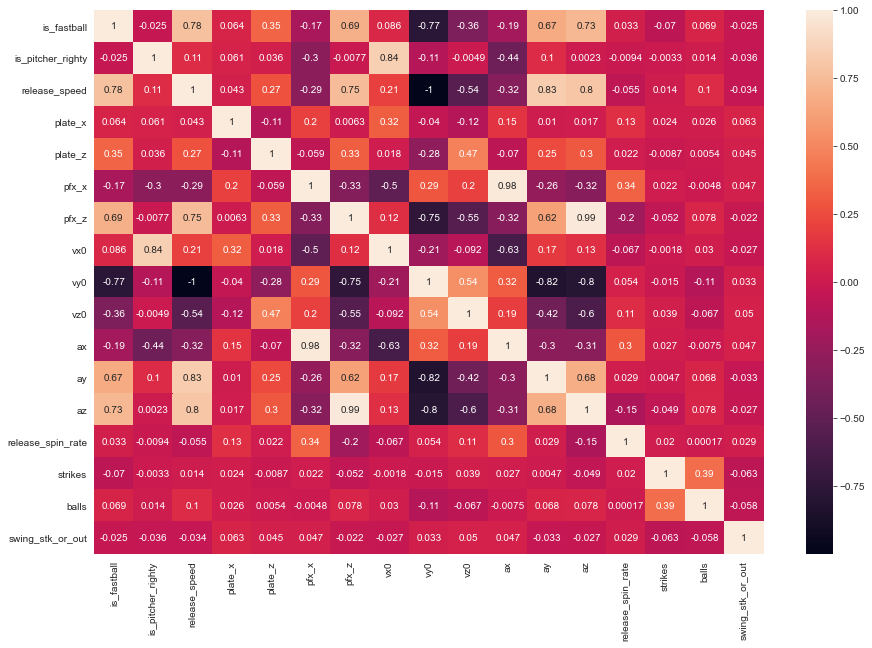

In [39]:
corr = model_df.corr()
plt.figure(figsize=(15,10))
ax= plt.subplot()
sns.heatmap(corr, ax=ax, annot=True);

From this heatmap, I've gathered some useful information for our models moving forward.  Firstly, "release_speed" is the same as "vy0", just in a different metric.  Additionally, the acceleration fields ("ax", "ay", and "az" fields) are also highly correlated with the velocity fields.  For this reason, I will be removing the acceleration fields from our model. Aside from this, the only other fields with high correlation with one another is the "is_fastball" and "vy0", namely the velocity, which totally makes sense. But I'll keep this for now as the value does not exceed 0.8 in either direction.  Additionally, we have a class imbalance issue that I will try to address.

In [40]:
model_df = model_df.drop(['ax','ay','az','release_speed'], axis=1)

In [41]:
X_train = X_train.drop(['ax','ay','az','release_speed'], axis=1)

In [42]:
X_test = X_test.drop(['ax','ay','az','release_speed'], axis=1)

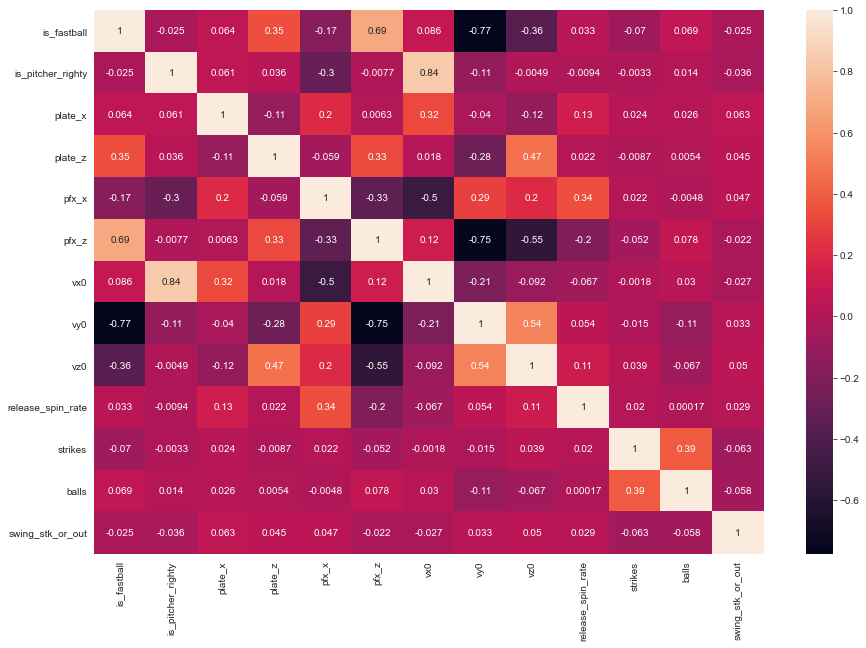

In [43]:
corr = model_df.corr()
plt.figure(figsize=(15,10))
ax= plt.subplot()
sns.heatmap(corr, ax=ax, annot=True);

In [44]:
# y_score = nb.decision_function(X_test)
# fpr, tpr, thresholds = roc_curve(y_test, y_score)


# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
# ax1.plot(fpr, tpr, color=BLUE, label='ROC Curve')
# ax1.plot([0,1], [0,1], color='red', ls=':') # Creating a diagonal line.
# ax1.set(
#     title='ROC Curve',
#     xlabel='False Positive Rate',
#     ylabel='True Positive Rate'
# )

## Model Iteration

I'm going to try a different approach now that we've removed some redundant features.


In [45]:
model_xgb = XGBClassifier(objective='multi:softmax', num_class=3)
#scale_pos_weight 
#model_xgb = XGBClassifier(scale_pos_weight=5)
# scale_pos_weight is the ratio of number of negative class to the positive class.

model_xgb.fit(X_train, y_train)
scores = cross_val_score(model_xgb, X_train,y_train)
print('cross-val-scores')
print(scores)
print('mean')
print(round(scores.mean(), 5))

cross-val-scores
[0.83021077 0.81733021 0.78922717 0.81498829 0.81594373]
mean
0.81354


In [133]:
pred_xgb_test = model_xgb.predict(X_test)
print(classification_report(y_test, pred_xgb_test))

              precision    recall  f1-score   support

          -1       0.72      0.23      0.35       142
           0       0.82      0.86      0.84       532
           1       0.78      0.85      0.82       750

    accuracy                           0.79      1424
   macro avg       0.77      0.65      0.67      1424
weighted avg       0.79      0.79      0.78      1424



In [134]:
pred_xgb_train = model_xgb.predict(X_train)
print(classification_report(y_train, pred_xgb_train))

              precision    recall  f1-score   support

          -1       1.00      0.98      0.99       385
           0       1.00      1.00      1.00      1560
           1       1.00      1.00      1.00      2324

    accuracy                           1.00      4269
   macro avg       1.00      0.99      1.00      4269
weighted avg       1.00      1.00      1.00      4269



In [135]:
confusion_matrix(y_test,pred_xgb_test)

array([[ 33,   4, 105],
       [  0, 458,  74],
       [ 13,  96, 641]], dtype=int64)

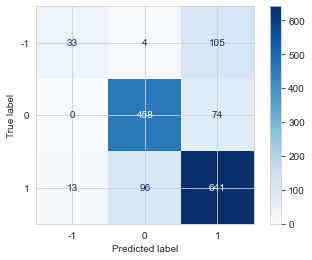

In [139]:
sns.set_style("whitegrid")
plot_confusion_matrix(model_xgb, X_test, y_test, cmap='Blues')
plt.show()  

Definitely concerned that we are overfitting here with our use of XGBoost. We have nearly 100% across the board on our train data. Additionally, the "-1" outcomes are not fantastic. This means we are not predicting these very accurately.  A recall of 0.23 means that this model is missing a lot of negative pitcher outcomes and the model is very "picky".  It is predicting correctly on negative pitcher outcomes 72% of the time, but it is missing a LOT of negative pitcher outcome where it was predicted to be positive. However, since these events of "extremely negative outcomes for the pitcher" are much more sparse per pitch, I think this is acceptable as long as we are attempting to address the class imbalance.

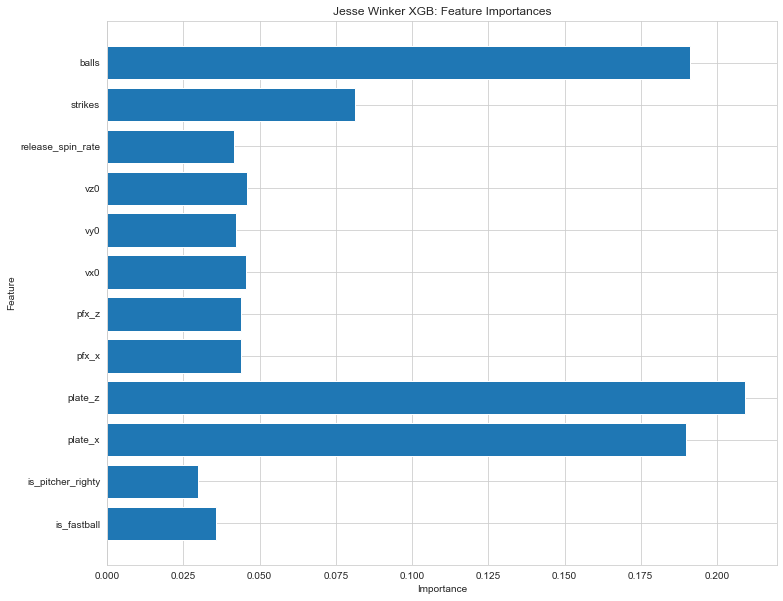

In [151]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
barlist = plt.barh(y=X_train.columns, width=model_xgb.feature_importances_)
ax.set(
    title="Jesse Winker XGB: Feature Importances",
    ylabel="Feature",
    xlabel="Importance"
);

Moving forward, I'd like to take a look at the entire Reds starting hitting lineup and model it as well.  From there, we can compare/contrast this with a single hitter's weaknesses and strengths.


## Application To Entire Team


In [54]:
player_info__all_reds = playerid_lookup('india','jonathan')

player_info_temp = playerid_lookup('winker','jesse')
player_info__all_reds= player_info__all_reds.append(player_info_temp, ignore_index=True)

player_info_temp = playerid_lookup('naquin','tyler')
player_info__all_reds= player_info__all_reds.append(player_info_temp, ignore_index=True)

player_info_temp = playerid_lookup('castellanos','nick')
player_info__all_reds= player_info__all_reds.append(player_info_temp, ignore_index=True)

player_info_temp = playerid_lookup('votto','joey')
player_info__all_reds= player_info__all_reds.append(player_info_temp, ignore_index=True)

player_info_temp = playerid_lookup('suarez','eugenio')
player_info__all_reds= player_info__all_reds.append(player_info_temp, ignore_index=True)

player_info_temp = playerid_lookup('farmer','kyle')
player_info__all_reds= player_info__all_reds.append(player_info_temp, ignore_index=True)

player_info_temp = playerid_lookup('barnhart','tucker')
player_info__all_reds= player_info__all_reds.append(player_info_temp, ignore_index=True)

player_info__all_reds.head(8)


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,india,jonathan,663697,indij001,indiajo01,-1,2021.0,2021.0
1,winker,jesse,608385,winkj002,winkeje01,13590,2017.0,2021.0
2,naquin,tyler,571980,naqut001,naquity01,13359,2016.0,2021.0
3,castellanos,nick,592206,castn001,casteni01,11737,2013.0,2021.0
4,votto,joey,458015,vottj001,vottojo01,4314,2007.0,2021.0
5,suarez,eugenio,553993,suare001,suareeu01,12552,2014.0,2021.0
6,farmer,kyle,571657,farmk001,farmeky01,14813,2017.0,2021.0
7,barnhart,tucker,571466,barnt001,barnhtu01,10200,2014.0,2021.0


In [55]:
all_reds_df = pd.DataFrame()

for index, row in player_info__all_reds.iterrows():
    temp_id = row['key_mlbam']
    first_year = int(row['mlb_played_first'])
    if first_year < 2018:
        first_year = 2018 #4 year cap, so that players with longer careers
                          #are not over-influencing our model
    start_date = str(first_year)+'-01-01'
    temp_df = statcast_batter(start_date,'2021-08-01', temp_id)
    all_reds_df= all_reds_df.append(temp_df, ignore_index=True)

print(all_reds_df.shape)
all_reds_df.head()

Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
(40524, 92)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,CU,2021-08-01,76.7,-1.30,5.42,"India, Jonathan",663697,573186,strikeout,called_strike,NaN,NaN,NaN,NaN,3.0,Jonathan India called out on strikes.,R,R,R,NYM,CIN,S,2.0,NaN,2,2,2021,1.16,-0.73,0.56,3.29,NaN,NaN,NaN,2,5,Top,NaN,NaN,NaN,NaN,621512.0,NaN,NaN,1.794488,-111.623450,3.717307,9.406717,20.264958,-39.134393,3.24,1.45,NaN,NaN,NaN,75.3,2521.0,5.3,633129,573186,621512.0,624413.0,643446.0,592273.0,595879.0,642086.0,607680.0,624424.0,55.20,NaN,NaN,0.0,1.0,0.0,0.0,NaN,32,5,Curveball,0,1,1,0,1,0,1,0,Infield shift,Standard,44.0,0.011,-0.090
1,SL,2021-08-01,87.2,-1.24,5.26,"India, Jonathan",663697,573186,NaN,ball,NaN,NaN,NaN,NaN,14.0,Jonathan India called out on strikes.,R,R,R,NYM,CIN,B,NaN,NaN,1,2,2021,0.52,-0.14,1.45,0.09,NaN,NaN,NaN,2,5,Top,NaN,NaN,NaN,NaN,621512.0,NaN,NaN,5.359072,-126.981562,-6.001233,4.605688,23.808570,-32.705521,3.14,1.41,NaN,NaN,NaN,86.7,2733.0,5.8,633129,573186,621512.0,624413.0,643446.0,592273.0,595879.0,642086.0,607680.0,624424.0,54.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,4,Slider,0,1,1,0,1,0,1,0,Infield shift,Standard,46.0,0.000,0.018
2,FS,2021-08-01,88.9,-1.28,5.25,"India, Jonathan",663697,573186,NaN,swinging_strike,NaN,NaN,NaN,NaN,13.0,Jonathan India called out on strikes.,R,R,R,NYM,CIN,S,NaN,NaN,1,1,2021,-0.82,-0.25,-0.47,1.11,NaN,NaN,NaN,2,5,Top,NaN,NaN,NaN,NaN,621512.0,NaN,NaN,3.646525,-129.613057,-3.669843,-9.998630,23.197158,-34.515494,3.37,1.53,NaN,NaN,NaN,88.6,1821.0,5.7,633129,573186,621512.0,624413.0,643446.0,592273.0,595879.0,642086.0,607680.0,624424.0,54.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,3,Split-Finger,0,1,1,0,1,0,1,0,Infield shift,Standard,242.0,0.000,-0.028
3,SL,2021-08-01,87.1,-1.30,5.25,"India, Jonathan",663697,573186,NaN,called_strike,NaN,NaN,NaN,NaN,14.0,Jonathan India called out on strikes.,R,R,R,NYM,CIN,S,NaN,NaN,1,0,2021,0.64,0.19,0.89,1.64,NaN,NaN,NaN,2,5,Top,NaN,NaN,NaN,NaN,621512.0,NaN,NaN,3.911296,-126.847473,-2.949432,6.257274,23.310058,-29.805443,3.38,1.43,NaN,NaN,NaN,86.7,2734.0,5.8,633129,573186,621512.0,624413.0,643446.0,592273.0,595879.0,642086.0,607680.0,624424.0,54.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,2,Slider,0,1,1,0,1,0,1,0,Infield shift,Standard,50.0,0.000,-0.021
4,SL,2021-08-01,86.0,-1.25,5.20,"India, Jonathan",663697,573186,NaN,ball,NaN,NaN,NaN,NaN,14.0,Jonathan India called out on strikes.,R,R,R,NYM,CIN,B,NaN,NaN,0,0,2021,0.84,0.28,0.17,0.94,NaN,NaN,NaN,2,5,Top,NaN,NaN,NaN,NaN,621512.0,NaN,NaN,1.649699,-125.304526,-4.470958,8.656878,22.435783,-28.562121,3.38,1.49,NaN,NaN,NaN,85.7,2744.0,5.8,633129,573186,621512.0,624413.0,643446.0,592273.0,595879.0,642086.0,607680.0,624424.0,54.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,1,Slider,0,1,1,0,1,0,1,0,Infield shift,Standard,57.0,0.000,0.016


40,000 pitches were given to the current active 2021 Reds lineup over the past 4 seasons.  I am now going to clean this data and engineer our fields in the same way so that we can compare the models effectively.

In [56]:
print(all_reds_df['pitch_type'].isna().sum())
print(all_reds_df['release_speed'].isna().sum())
print(all_reds_df['plate_x'].isna().sum())
print(all_reds_df['plate_z'].isna().sum())

385
385
388
388


In [57]:
reds_cleaned_df = all_reds_df.loc[(all_reds_df['pitch_type'].notnull()) & (all_reds_df['release_speed'].notnull())
            & (all_reds_df['plate_x'].notnull()) & (all_reds_df['plate_z'].notnull())]
print(reds_cleaned_df.shape)
reds_cleaned_df.head()

(40130, 92)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,CU,2021-08-01,76.7,-1.30,5.42,"India, Jonathan",663697,573186,strikeout,called_strike,NaN,NaN,NaN,NaN,3.0,Jonathan India called out on strikes.,R,R,R,NYM,CIN,S,2.0,NaN,2,2,2021,1.16,-0.73,0.56,3.29,NaN,NaN,NaN,2,5,Top,NaN,NaN,NaN,NaN,621512.0,NaN,NaN,1.794488,-111.623450,3.717307,9.406717,20.264958,-39.134393,3.24,1.45,NaN,NaN,NaN,75.3,2521.0,5.3,633129,573186,621512.0,624413.0,643446.0,592273.0,595879.0,642086.0,607680.0,624424.0,55.20,NaN,NaN,0.0,1.0,0.0,0.0,NaN,32,5,Curveball,0,1,1,0,1,0,1,0,Infield shift,Standard,44.0,0.011,-0.090
1,SL,2021-08-01,87.2,-1.24,5.26,"India, Jonathan",663697,573186,NaN,ball,NaN,NaN,NaN,NaN,14.0,Jonathan India called out on strikes.,R,R,R,NYM,CIN,B,NaN,NaN,1,2,2021,0.52,-0.14,1.45,0.09,NaN,NaN,NaN,2,5,Top,NaN,NaN,NaN,NaN,621512.0,NaN,NaN,5.359072,-126.981562,-6.001233,4.605688,23.808570,-32.705521,3.14,1.41,NaN,NaN,NaN,86.7,2733.0,5.8,633129,573186,621512.0,624413.0,643446.0,592273.0,595879.0,642086.0,607680.0,624424.0,54.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,4,Slider,0,1,1,0,1,0,1,0,Infield shift,Standard,46.0,0.000,0.018
2,FS,2021-08-01,88.9,-1.28,5.25,"India, Jonathan",663697,573186,NaN,swinging_strike,NaN,NaN,NaN,NaN,13.0,Jonathan India called out on strikes.,R,R,R,NYM,CIN,S,NaN,NaN,1,1,2021,-0.82,-0.25,-0.47,1.11,NaN,NaN,NaN,2,5,Top,NaN,NaN,NaN,NaN,621512.0,NaN,NaN,3.646525,-129.613057,-3.669843,-9.998630,23.197158,-34.515494,3.37,1.53,NaN,NaN,NaN,88.6,1821.0,5.7,633129,573186,621512.0,624413.0,643446.0,592273.0,595879.0,642086.0,607680.0,624424.0,54.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,3,Split-Finger,0,1,1,0,1,0,1,0,Infield shift,Standard,242.0,0.000,-0.028
3,SL,2021-08-01,87.1,-1.30,5.25,"India, Jonathan",663697,573186,NaN,called_strike,NaN,NaN,NaN,NaN,14.0,Jonathan India called out on strikes.,R,R,R,NYM,CIN,S,NaN,NaN,1,0,2021,0.64,0.19,0.89,1.64,NaN,NaN,NaN,2,5,Top,NaN,NaN,NaN,NaN,621512.0,NaN,NaN,3.911296,-126.847473,-2.949432,6.257274,23.310058,-29.805443,3.38,1.43,NaN,NaN,NaN,86.7,2734.0,5.8,633129,573186,621512.0,624413.0,643446.0,592273.0,595879.0,642086.0,607680.0,624424.0,54.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,2,Slider,0,1,1,0,1,0,1,0,Infield shift,Standard,50.0,0.000,-0.021
4,SL,2021-08-01,86.0,-1.25,5.20,"India, Jonathan",663697,573186,NaN,ball,NaN,NaN,NaN,NaN,14.0,Jonathan India called out on strikes.,R,R,R,NYM,CIN,B,NaN,NaN,0,0,2021,0.84,0.28,0.17,0.94,NaN,NaN,NaN,2,5,Top,NaN,NaN,NaN,NaN,621512.0,NaN,NaN,1.649699,-125.304526,-4.470958,8.656878,22.435783,-28.562121,3.38,1.49,NaN,NaN,NaN,85.7,2744.0,5.8,633129,573186,621512.0,624413.0,643446.0,592273.0,595879.0,642086.0,607680.0,624424.0,54.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,1,Slider,0,1,1,0,1,0,1,0,Infield shift,Standard,57.0,0.000,0.016


In [58]:
reds_cleaned_df['swing_stk_or_out'] = 0

<ipython-input-58-6e8988925a3a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reds_cleaned_df['swing_stk_or_out'] = 0


In [59]:
reds_cleaned_df['events'].unique().tolist()

['strikeout',
 nan,
 'double',
 'field_out',
 'strikeout_double_play',
 'walk',
 'hit_by_pitch',
 'home_run',
 'grounded_into_double_play',
 'single',
 'force_out',
 'field_error',
 'caught_stealing_2b',
 'fielders_choice',
 'sac_bunt',
 'triple',
 'sac_fly',
 'fielders_choice_out',
 'double_play',
 'caught_stealing_3b',
 'other_out',
 'sac_fly_double_play']

In [60]:
reds_cleaned_df.loc[reds_cleaned_df['description'].isin(['hit_into_play', 'foul', 'swinging_strike',
 'called_strike', 'foul_tip', 'swinging_strike_blocked', 'foul_bunt',
 'missed_bunt']), 'swing_stk_or_out'] = 1

reds_cleaned_df.loc[reds_cleaned_df['events'].isin(['double', 'walk', 'single',
 'home_run', 'triple', 'sac_fly']), 'swing_stk_or_out'] = -1

C:\Users\Darko\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [61]:
reds_cleaned_df['is_fastball'] = 0

reds_cleaned_df.loc[reds_cleaned_df['pitch_type'].isin(fastballs), 'is_fastball'] = 1

<ipython-input-61-aa7fab14ad18>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reds_cleaned_df['is_fastball'] = 0


In [62]:
reds_cleaned_df['is_pitcher_righty'] = 0

reds_cleaned_df.loc[reds_cleaned_df['p_throws'] == 'R', 'is_pitcher_righty'] = 1

<ipython-input-62-45775579286b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reds_cleaned_df['is_pitcher_righty'] = 0


In [63]:
reds_cleaned_df = reds_cleaned_df.loc[(reds_cleaned_df['release_spin_rate'].notnull())]

Now that we have engineered some of these fields in the same way, let's just take the relevant fields for our model (minus the ones that are highly correlated with one another, removing redundant data) to get our dataframe 100% ready to be modeled.

In [64]:
reds_cleaned_df = reds_cleaned_df[['is_fastball','is_pitcher_righty',
                  'plate_x','plate_z','pfx_x','pfx_z','vx0','vy0','vz0',
                  'release_spin_rate','strikes','balls','swing_stk_or_out']]
print(reds_cleaned_df.shape)


(39667, 13)


In [65]:
reds_cleaned_df = reds_cleaned_df.iloc[::-1]

In [66]:
reds_cleaned_df.head(50)

,is_fastball,is_pitcher_righty,plate_x,plate_z,pfx_x,pfx_z,vx0,vy0,vz0,release_spin_rate,strikes,balls,swing_stk_or_out
40523,1,1,0.79,1.78,0.14,0.67,10.694794,-128.034071,-2.690493,2328.0,0,0,1
40522,1,1,-0.44,4.20,-0.73,1.31,9.845083,-134.803320,1.172709,2477.0,1,0,0
40521,1,1,-0.26,3.04,0.21,0.53,7.714816,-129.209644,0.342298,2466.0,1,1,1
40520,1,1,-0.43,3.96,-0.86,1.28,9.636839,-136.181319,0.353158,2451.0,2,1,0
40519,1,1,-0.71,2.97,-0.92,1.33,9.704695,-136.133683,-2.100787,2460.0,2,2,1
40518,0,1,-0.72,1.15,-1.38,-0.12,9.436433,-120.857336,-2.190158,1539.0,0,0,1
40517,1,1,-0.24,2.82,-0.97,1.34,10.862571,-134.283023,-2.329961,2402.0,1,0,1
40516,1,1,1.60,1.23,0.20,0.75,12.223644,-127.343325,-4.136684,2345.0,2,0,0
40515,1,1,0.74,2.43,-0.05,0.82,11.109905,-129.339638,-1.473212,2328.0,2,1,1
40514,1,1,-1.24,2.03,-1.09,1.07,8.400144,-130.950951,-3.317254,2400.0,0,0,0


## Full Team Modeling

In [67]:
X1_reds= reds_cleaned_df.drop('swing_stk_or_out', 1)
y1_reds = reds_cleaned_df['swing_stk_or_out']

X_train_reds, X_test_reds, y_train_reds, y_test_reds = train_test_split(X1_reds,y1_reds)

X_train_reds.shape, X_test_reds.shape, y_train_reds.shape, y_test_reds.shape

((29750, 12), (9917, 12), (29750,), (9917,))

In [68]:
reds_model_xgb = XGBClassifier(objective='multi:softmax', num_class=3)
reds_model_xgb.fit(X_train_reds, y_train_reds)
scores = cross_val_score(reds_model_xgb, X_train_reds,y_train_reds)
print('cross-val-scores')
print(scores)
print('mean')
print(round(scores.mean(), 5))

cross-val-scores
[0.80403361 0.8010084  0.80319328 0.80420168 0.80436975]
mean
0.80336


In [69]:
pred_xgb_reds = reds_model_xgb.predict(X_test_reds)
print(classification_report(y_test_reds, pred_xgb_reds))

              precision    recall  f1-score   support

          -1       0.72      0.22      0.33       851
           0       0.81      0.84      0.83      3459
           1       0.80      0.87      0.84      5607

    accuracy                           0.81      9917
   macro avg       0.78      0.64      0.67      9917
weighted avg       0.80      0.81      0.79      9917



In [70]:
pred_xgb_reds = reds_model_xgb.predict(X_train_reds)
print(classification_report(y_train_reds, pred_xgb_reds))

              precision    recall  f1-score   support

          -1       0.98      0.33      0.50      2519
           0       0.89      0.91      0.90     10613
           1       0.86      0.94      0.90     16618

    accuracy                           0.87     29750
   macro avg       0.91      0.73      0.76     29750
weighted avg       0.88      0.87      0.86     29750



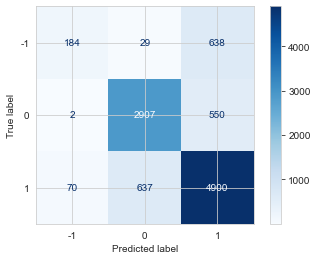

In [140]:
sns.set_style("whitegrid")
plot_confusion_matrix(reds_model_xgb, X_test_reds, y_test_reds, cmap='Blues')
plt.show()

Our confusion matrix looks very similar to our last model, and we have similar precision and recall values for the "negative pitcher outcomes" class.  However, this model is not overfitting nearly as much. Values around 87% in our training data indicate that we seem to have addressed the overfitting for this model.  Unfortunately, the confusion matrix looks similar and we have similar issues in this model- although we have a high rate for predicting true positives, we seem to have issues predicting negative pitcher outcomes when we think they will result in a positive outcome.

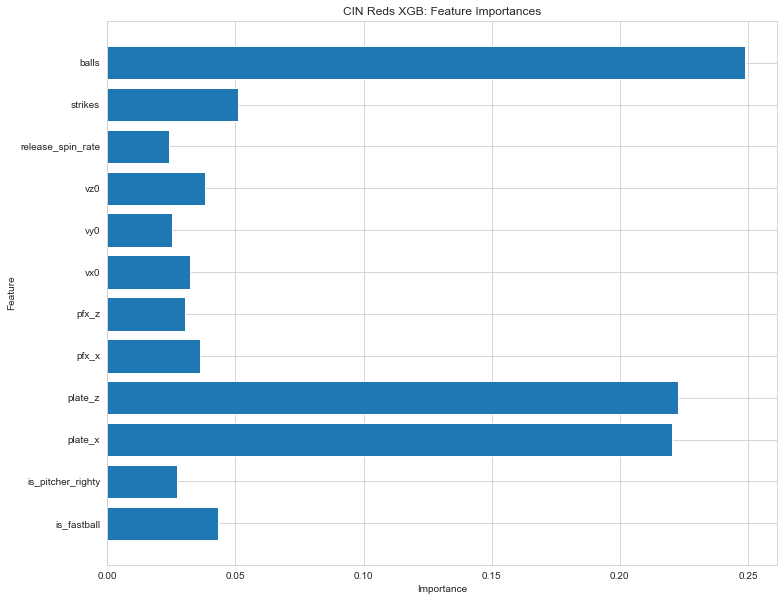

In [152]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
barlist = plt.barh(y=X_train_reds.columns, width=reds_model_xgb.feature_importances_)
ax.set(
    title="CIN Reds XGB: Feature Importances",
    ylabel="Feature",
    xlabel="Importance"
);

The results are actually extremely similar.  As we can see, there are 3 main determining factors that I can sum up in just a few words- location, location, location.  The location of the pitch, namely the plate_z and plate_x values, are the 2nd highest determining factors in the outcome of a pitch having a positive or negative outcome for the pitcher.  This is a similar feature importance value we saw just looking at Jesse Winker's model as well.  Similarly, the # of balls in the count has the highest importance for the model against the Reds.  This could mean several things.  Firstly, if a pitcher has thrown a high number of balls in the at bat, the hitter now has a HUGE advantage as he knows a pitch in the strike zone is coming- something he can potentially do damage with.  Having a 0-0 count, a batter essentially has no idea what the pitcher could be going with in the at-bat. No previous pitches to predict off of, and the batter unsure if the pitcher wants to attack the strike zone early or get him chasing at balls early.

Additionally, we once again see that the handedness of the pitcher has the LOWEST importance in both Jesse Winker and the entire Red's team's model.  However, because the batters in the Reds lineup are both right and left handed, this may seem to make sense.  As for Jesse Winker, this may just speak to his ability to be able to hit extremely well against both right and left handed pitchers.

***

This has given me an idea. I want to turn this problem into a binary classification problem to potentially simplify the model. Having this "neutral" outcome of throwing a "ball" might be confusing our model, because really it's only a positive/negative outcome depending on the context.  I'm going to drop the "neutral" outcome pitches and see what our model comes up with for a binary classification model for the entire Reds team.

## "No Neutrals" Model

In [72]:
no_neutrals_df = reds_cleaned_df
no_neutrals_df.head(5)

,is_fastball,is_pitcher_righty,plate_x,plate_z,pfx_x,pfx_z,vx0,vy0,vz0,release_spin_rate,strikes,balls,swing_stk_or_out
40523,1,1,0.79,1.78,0.14,0.67,10.694794,-128.034071,-2.690493,2328.0,0,0,1
40522,1,1,-0.44,4.20,-0.73,1.31,9.845083,-134.803320,1.172709,2477.0,1,0,0
40521,1,1,-0.26,3.04,0.21,0.53,7.714816,-129.209644,0.342298,2466.0,1,1,1
40520,1,1,-0.43,3.96,-0.86,1.28,9.636839,-136.181319,0.353158,2451.0,2,1,0
40519,1,1,-0.71,2.97,-0.92,1.33,9.704695,-136.133683,-2.100787,2460.0,2,2,1


In [73]:
no_neutrals_df['favors_pitcher'] = no_neutrals_df['swing_stk_or_out']
no_neutrals_df = no_neutrals_df.drop('swing_stk_or_out',axis=1)

In [74]:
no_neutrals_df.head(20)

,is_fastball,is_pitcher_righty,plate_x,plate_z,pfx_x,pfx_z,vx0,vy0,vz0,release_spin_rate,strikes,balls,favors_pitcher
40523,1,1,0.79,1.78,0.14,0.67,10.694794,-128.034071,-2.690493,2328.0,0,0,1
40522,1,1,-0.44,4.20,-0.73,1.31,9.845083,-134.803320,1.172709,2477.0,1,0,0
40521,1,1,-0.26,3.04,0.21,0.53,7.714816,-129.209644,0.342298,2466.0,1,1,1
40520,1,1,-0.43,3.96,-0.86,1.28,9.636839,-136.181319,0.353158,2451.0,2,1,0
40519,1,1,-0.71,2.97,-0.92,1.33,9.704695,-136.133683,-2.100787,2460.0,2,2,1
40518,0,1,-0.72,1.15,-1.38,-0.12,9.436433,-120.857336,-2.190158,1539.0,0,0,1
40517,1,1,-0.24,2.82,-0.97,1.34,10.862571,-134.283023,-2.329961,2402.0,1,0,1
40516,1,1,1.60,1.23,0.20,0.75,12.223644,-127.343325,-4.136684,2345.0,2,0,0
40515,1,1,0.74,2.43,-0.05,0.82,11.109905,-129.339638,-1.473212,2328.0,2,1,1
40514,1,1,-1.24,2.03,-1.09,1.07,8.400144,-130.950951,-3.317254,2400.0,0,0,0


In [75]:
no_neutrals_df = no_neutrals_df[no_neutrals_df['favors_pitcher'] != 0]

In [76]:
no_neutrals_df.shape

(25595, 13)

In [77]:
no_neutrals_df['favors_hitter_binary'] = 1
no_neutrals_df.loc[no_neutrals_df['favors_pitcher']==1, 'favors_hitter_binary'] = 0

In [78]:
no_neutrals_df = no_neutrals_df.drop('favors_pitcher',axis=1)

In [79]:
no_neutrals_df.head(20)

,is_fastball,is_pitcher_righty,plate_x,plate_z,pfx_x,pfx_z,vx0,vy0,vz0,release_spin_rate,strikes,balls,favors_hitter_binary
40523,1,1,0.79,1.78,0.14,0.67,10.694794,-128.034071,-2.690493,2328.0,0,0,0
40521,1,1,-0.26,3.04,0.21,0.53,7.714816,-129.209644,0.342298,2466.0,1,1,0
40519,1,1,-0.71,2.97,-0.92,1.33,9.704695,-136.133683,-2.100787,2460.0,2,2,0
40518,0,1,-0.72,1.15,-1.38,-0.12,9.436433,-120.857336,-2.190158,1539.0,0,0,0
40517,1,1,-0.24,2.82,-0.97,1.34,10.862571,-134.283023,-2.329961,2402.0,1,0,0
40515,1,1,0.74,2.43,-0.05,0.82,11.109905,-129.339638,-1.473212,2328.0,2,1,0
40513,0,1,-0.81,1.89,-1.40,0.34,8.790804,-117.626935,-0.914291,1390.0,0,1,0
40510,1,1,0.07,2.28,-1.11,1.10,11.833605,-135.417998,-3.177358,2642.0,1,3,0
40509,0,0,-1.13,1.51,0.03,0.43,-4.607033,-119.098524,-4.207685,1978.0,0,0,0
40507,1,0,-0.50,1.70,1.36,1.09,-6.362155,-132.919609,-7.095153,1782.0,1,1,0


In [80]:
X1_nn= no_neutrals_df.drop('favors_hitter_binary', 1)
y1_nn = no_neutrals_df['favors_hitter_binary']

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X1_nn,y1_nn)

X_train_nn.shape, X_test_nn.shape, y_train_nn.shape, y_test_nn.shape

((19196, 12), (6399, 12), (19196,), (6399,))

In [81]:
no_neutrals_df['favors_hitter_binary'].value_counts()

0    22225
1     3370
Name: favors_hitter_binary, dtype: int64

In [82]:
nn_model_xgb = XGBClassifier(scale_pos_weight=6) #6x value count diff
nn_model_xgb.fit(X_train_nn, y_train_nn)
scores = cross_val_score(nn_model_xgb, X_train_nn,y_train_nn)
print('cross-val-scores')
print(scores)
print('mean')
print(round(scores.mean(), 5))

cross-val-scores
[0.79322917 0.798385   0.80854389 0.81557697 0.81166971]
mean
0.80548


In [83]:
pred_xgb_nn = nn_model_xgb.predict(X_test_nn)
print(classification_report(y_test_nn, pred_xgb_nn))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88      5588
           1       0.29      0.39      0.33       811

    accuracy                           0.80      6399
   macro avg       0.60      0.62      0.61      6399
weighted avg       0.83      0.80      0.81      6399



In [84]:
pred_xgb_nn = nn_model_xgb.predict(X_train_nn)
print(classification_report(y_train_nn, pred_xgb_nn))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95     16637
           1       0.64      0.93      0.76      2559

    accuracy                           0.92     19196
   macro avg       0.81      0.92      0.86     19196
weighted avg       0.94      0.92      0.93     19196



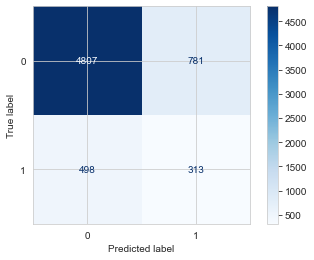

In [141]:
sns.set_style("whitegrid")
plot_confusion_matrix(nn_model_xgb, X_test_nn, y_test_nn, cmap='Blues')
plt.show()

Although the confusion matrix here looks different, it is essentially just inverted.  This is because we flipped one of our engineered fields into a positive hitter outcome instead, in order to address the binary class imbalance through the use of the "scale_pos_weight" parameter. If only there was a "scale_neg_weight", I could have avoiding needing to do this. Regardless, the same issue has carried over into our binary classification problem as well.  In fact, it actually significantly hurt our ability to predict true positives in this model. Namely, our model is just NOT predicting negative hitter outcomes correctly in 70% of all cases, which is not ideal.

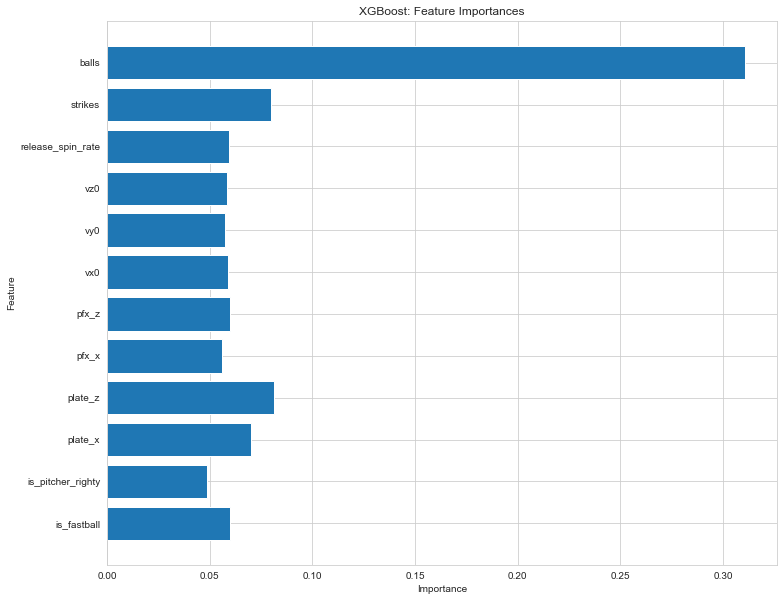

In [85]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
barlist = plt.barh(y=X_train_nn.columns, width=nn_model_xgb.feature_importances_)
ax.set(
    title="XGBoost: Feature Importances",
    ylabel="Feature",
    xlabel="Importance"
);

Definitely seeing a LOT of similarities in this model's feature importances and classification reports with very few differences. Still top 3 importances in "balls" and location data, just less importances on location than in previous models.  However, the number of strikes in this model is one of the most important predictors for pitcher success, which makes sense, as 3 strikes is a strikeout. That's alright though. It was worth investigating the "scale_pos_weight" and the low precision, recall, and f1-scores for the minority class. Still predicting at about 81.2% of the time as well, essentially no improvement and losing information (the 3rd class of neutral outcome) in this binary classification.

***

## Random Forest


In [86]:
reds_cleaned_df = reds_cleaned_df.drop('swing_stk_or_out', axis=1)

In [87]:
reds_cleaned_df.head(40)

,is_fastball,is_pitcher_righty,plate_x,plate_z,pfx_x,pfx_z,vx0,vy0,vz0,release_spin_rate,strikes,balls,favors_pitcher
40523,1,1,0.79,1.78,0.14,0.67,10.694794,-128.034071,-2.690493,2328.0,0,0,1
40522,1,1,-0.44,4.20,-0.73,1.31,9.845083,-134.803320,1.172709,2477.0,1,0,0
40521,1,1,-0.26,3.04,0.21,0.53,7.714816,-129.209644,0.342298,2466.0,1,1,1
40520,1,1,-0.43,3.96,-0.86,1.28,9.636839,-136.181319,0.353158,2451.0,2,1,0
40519,1,1,-0.71,2.97,-0.92,1.33,9.704695,-136.133683,-2.100787,2460.0,2,2,1
40518,0,1,-0.72,1.15,-1.38,-0.12,9.436433,-120.857336,-2.190158,1539.0,0,0,1
40517,1,1,-0.24,2.82,-0.97,1.34,10.862571,-134.283023,-2.329961,2402.0,1,0,1
40516,1,1,1.60,1.23,0.20,0.75,12.223644,-127.343325,-4.136684,2345.0,2,0,0
40515,1,1,0.74,2.43,-0.05,0.82,11.109905,-129.339638,-1.473212,2328.0,2,1,1
40514,1,1,-1.24,2.03,-1.09,1.07,8.400144,-130.950951,-3.317254,2400.0,0,0,0


In [117]:
bootstrap = [True, False]

param_grid = {
    "n_estimators": [25],
    "max_depth": [25],
    "min_samples_leaf": [2],
    "bootstrap": bootstrap,
}

rf = RandomForestClassifier()

rf_model = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, verbose=10, n_jobs=-1)
rf_model.fit(X_train_reds, y_train_reds)

#X_train_reds, X_test_reds, y_train_reds, y_test_reds = train_test_split(X1_reds,y1_reds)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    2.3s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.6s finished


GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [25],
                         'min_samples_leaf': [2], 'n_estimators': [25]},
             verbose=10)

In [118]:
y_pred = rf_model.predict(X_test_reds)
y_pred_label = list(y_pred)

print("Training--set score for SVM: %f" % rf_model.score(X_train_reds , y_train_reds))
print("Testing---set score for SVM: %f" % rf_model.score(X_test_reds  , y_test_reds ))

Training set score for SVM: 0.938756
Testing  set score for SVM: 0.800645


In [131]:
# fig = plt.figure(figsize=(15, 10))
# plot_tree(rf_model.estimator, 
#           feature_names=X1_reds.columns,
#           class_names=["Pitcher Result"], 
#           filled=True, impurity=True, 
#           rounded=True)


## Results and Conclusion

***

What are the most important metrics that go into a pitch against the Reds? **The Current Ball Count and Pitch Location**

What is the least important metric that goes into a pitch against the Reds? **Spin Rate (surprisingly!!)**

***



To my surprise, the spin rate on a pitch seems to have little to do with the overall outcome of the pitch itself against both Jesse Winker and the Reds as a whole.  Additionally, the current ball count seems to have the most impact on predicting the outcome, according to our model.  This makes sense, as a high ball count indicates that the batter is in a highly favorable position.  The pitcher now needs to successfully throw a ball in the strike zone, or suffer another negative pitcher outcome in the form of a walk.  Pitch location also makes sense as an important predictive factor in our model.  A pitch in the dirt is unlikely to be swung at, resulting in a neutral outcome.  But a strike is within a certain combination of values.  Pitches right down the middle are likely to be crushed, but strikes on the corners are more likely to result in a strike.  Although the model has some recall issues, namely being unable to detect negative pitcher outcomes correctly, the overall accuracy is around 81%.

##  Future Work

I am now extremely curious as to whether this "spin rate" discussion just doesn't apply to the Reds, or if other teams are in the same boat.  I'd love to experiment further with more modeling that allows me to view feature importances- models for specific teams to compare and contrast, or perhaps a model for all MLB starters.  The Reds have a very good record this year, and this may be partly why- they're really able to handle balls with higher spin rate with less issues than others. Only more modeling and investigation will tell.

I'd also think that the player-specific models will do well in a game setting.  For these, we could narrow down our models to just specific pitch types and locations, to be able to create a tool that will be able to tell us the success rate of our next pitch, giving us a live decision in a game scenario.  I think that would be extremely valuable from an organization standpoint.